In [181]:
import kagglehub
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
import pandas as pd
from networkx.algorithms.community import louvain_communities
from collections import Counter
import re
from collections import defaultdict


# Download latest version
path = kagglehub.dataset_download("harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows")
print("Path to dataset files:", path)

df = pd.read_csv(f"{path}/imdb_top_1000.csv")
# print(df[:2])
print(df.info())

Path to dataset files: /Users/fridafrandsen/.cache/kagglehub/datasets/harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows/versions/1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Poster_Link    1000 non-null   object 
 1   Series_Title   1000 non-null   object 
 2   Released_Year  1000 non-null   object 
 3   Certificate    899 non-null    object 
 4   Runtime        1000 non-null   object 
 5   Genre          1000 non-null   object 
 6   IMDB_Rating    1000 non-null   float64
 7   Overview       1000 non-null   object 
 8   Meta_score     843 non-null    float64
 9   Director       1000 non-null   object 
 10  Star1          1000 non-null   object 
 11  Star2          1000 non-null   object 
 12  Star3          1000 non-null   object 
 13  Star4          1000 non-null   object 
 14  No_of_Votes    1000 non-null   int64  
 1

In [160]:
df = df.drop(columns=["Poster_Link", "Meta_score", "Certificate"])

In [161]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   1000 non-null   object 
 1   Released_Year  1000 non-null   object 
 2   Runtime        1000 non-null   object 
 3   Genre          1000 non-null   object 
 4   IMDB_Rating    1000 non-null   float64
 5   Overview       1000 non-null   object 
 6   Director       1000 non-null   object 
 7   Star1          1000 non-null   object 
 8   Star2          1000 non-null   object 
 9   Star3          1000 non-null   object 
 10  Star4          1000 non-null   object 
 11  No_of_Votes    1000 non-null   int64  
 12  Gross          831 non-null    object 
dtypes: float64(1), int64(1), object(11)
memory usage: 101.7+ KB
None


In [162]:
df = df.dropna().reset_index(drop=True)
print(df['Gross'])

0       28,341,469
1      134,966,411
2      534,858,444
3       57,300,000
4        4,360,000
          ...     
826        696,690
827      1,378,435
828    141,843,612
829     13,780,024
830     30,500,000
Name: Gross, Length: 831, dtype: object


In [163]:
df['Released_Year'] = (
    df['Released_Year']
    .astype(str)               # sikrer str
    .str.extract(r'(\d{4})')   # trækker første 4 cifre ud
    [0]                        # extract returnerer DataFrame → tag første kolonne
    .astype(float)             # konverter til float (så NaN tillades)
)

In [164]:
# Creating the graph
G = nx.Graph()

for i in range(len(df)):
    G.add_node(df['Series_Title'][i],
    release_year = int(df['Released_Year'][i]) if not pd.isna(df['Released_Year'][i]) else None,
    runtime = int((df['Runtime'][i]).replace(' min', '')),
    genre = (df['Genre'][i]).replace(" ", "").split(','),
    rating = float(df['IMDB_Rating'][i]),
    resume = df['Overview'][i],
    director = df['Director'][i],
    stars = [df['Star1'][i], df['Star2'][i], df['Star3'][i], df['Star4'][i]],
    no_of_votes = int(df['No_of_Votes'][i]),
    gross = int((df['Gross'][i]).replace(',', ''))
    )

print(G)
print(G.nodes['Up'])



Graph with 831 nodes and 0 edges
{'release_year': 2009, 'runtime': 96, 'genre': ['Animation', 'Adventure', 'Comedy'], 'rating': 8.2, 'resume': '78-year-old Carl Fredricksen travels to Paradise Falls in his house equipped with balloons, inadvertently taking a young stowaway.', 'director': 'Pete Docter', 'stars': ['Bob Peterson', 'Edward Asner', 'Jordan Nagai', 'John Ratzenberger'], 'no_of_votes': 935507, 'gross': 293004164}


In [165]:
# Adding edges between movies who share stars
titles = list(df['Series_Title'])
stars_list = df[['Star1', 'Star2', 'Star3', 'Star4']].values.tolist()

for i in range(len(titles)):
    for j in range(i + 1, len(titles)):
        if set(stars_list[i]) & set(stars_list[j]):
            G.add_edge(titles[i], titles[j])

In [207]:
sorted_nodes = sorted(G.nodes(data=True), key=lambda x: x[1]['gross'], reverse=True)
for name, data in sorted_nodes[:10]:
    print(name, data.get('gross'))

Star Wars: Episode VII - The Force Awakens 936662225
Avengers: Endgame 858373000
Avatar 760507625
Avengers: Infinity War 678815482
Titanic 659325379
The Avengers 623279547
Incredibles 2 608581744
The Dark Knight 534858444
Rogue One 532177324
The Dark Knight Rises 448139099


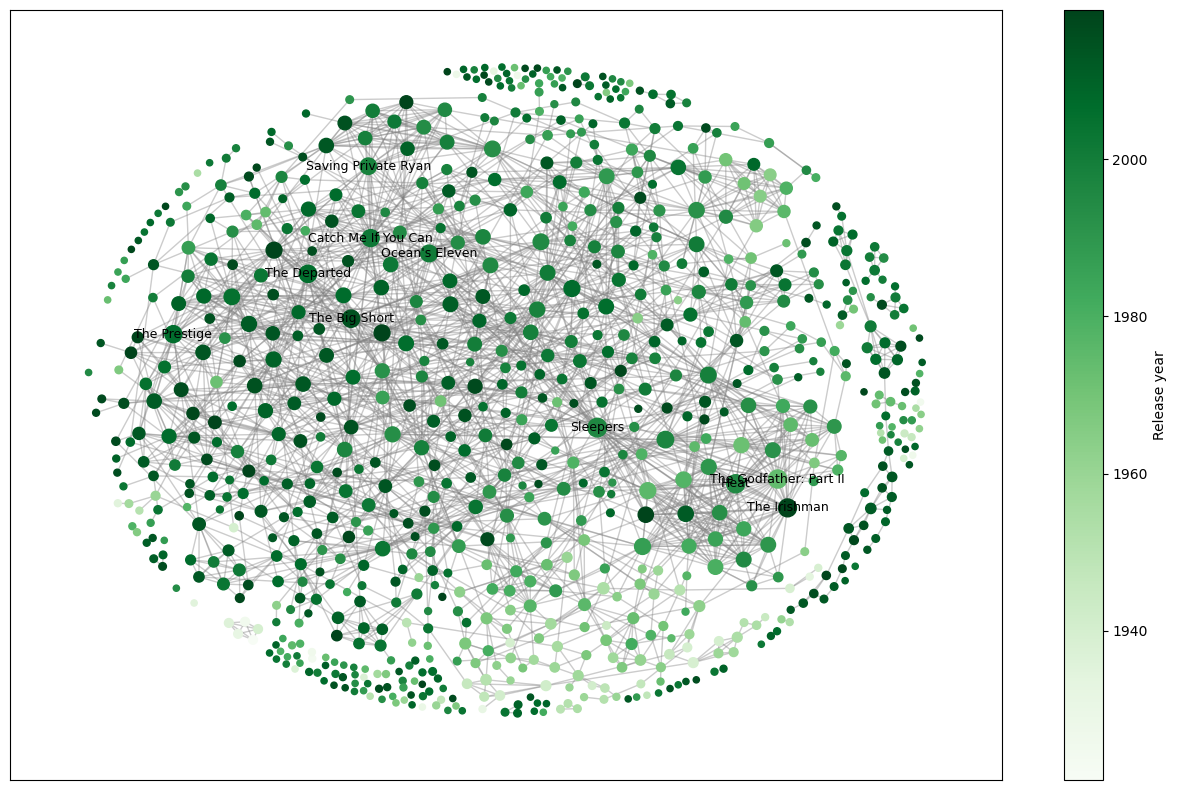

In [166]:
plt.style.use('default')

# Find node size
degrees = dict(G.degree())
node_sizes = [20 + deg * 5 for deg in degrees.values()] 

# Node colors
release_year = nx.get_node_attributes(G, "release_year")
node_colors = [release_year.get(n, 0) for n in G.nodes()]

pos = nx.forceatlas2_layout(G, max_iter=500, scaling_ratio=2.0, gravity=1.0, strong_gravity=True, seed=30)

plt.figure(figsize=(16, 10))
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.Greens, alpha=1)
nx.draw_networkx_edges(G, pos, edge_color="gray", alpha=0.4)

top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:10]
labels = {n: n for n in top_nodes}
nx.draw_networkx_labels(G, pos, labels, font_size=9, font_weight='normal') 

plt.colorbar(nodes, label="Release year")
plt.show()

In [167]:
isolated_nodes = list(nx.isolates(G))
print(f"Number of isolated nodes:", {len(isolated_nodes)})
G_no_isolates = G.copy()
G_no_isolates.remove_nodes_from(isolated_nodes)

Number of isolated nodes: {136}


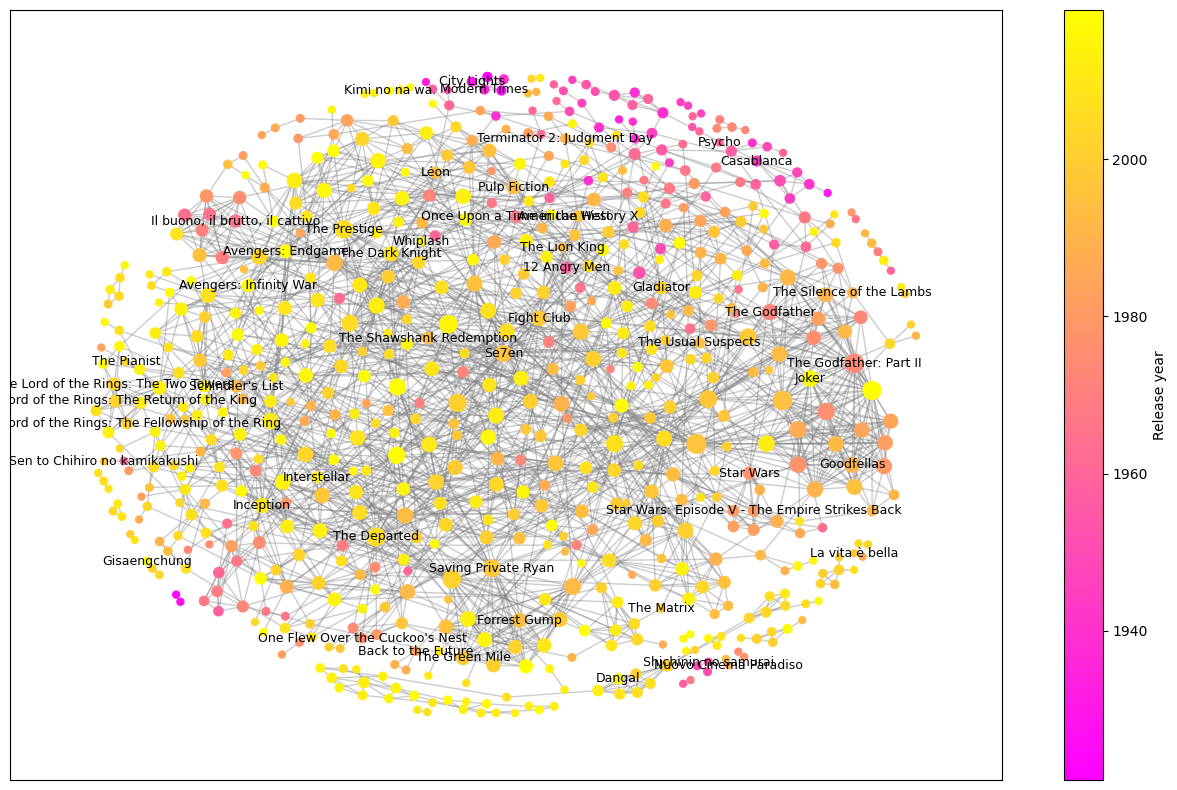

In [168]:
plt.style.use('default')

# # Find node size
degrees = dict(G_no_isolates.degree())
node_sizes = [20 + deg * 5 for deg in degrees.values()] 

# Node colors
release_year = nx.get_node_attributes(G, "release_year")
node_colors = [release_year.get(n, 0) for n in G_no_isolates.nodes()]

pos = nx.forceatlas2_layout(G_no_isolates, max_iter=500, scaling_ratio=2.0, gravity=1.0, strong_gravity=True, seed=30)

plt.figure(figsize=(16, 10))
nodes = nx.draw_networkx_nodes(G_no_isolates, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.spring, alpha=1)
nx.draw_networkx_edges(G_no_isolates, pos, edge_color="gray", alpha=0.4)

# top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:10]
# labels = {n: n for n in top_nodes}
# nx.draw_networkx_labels(G_no_isolates, pos, labels, font_size=9, font_weight='normal') 

random_nodes = list(degrees.keys())[:50]
labels = {n: n for n in random_nodes}
nx.draw_networkx_labels(G_no_isolates, pos, labels, font_size=9, font_weight='normal') 

plt.colorbar(nodes, label="Release year")
plt.show()

In [169]:
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G_largest = G.subgraph(Gcc[0])
print(G_largest)

Graph with 573 nodes and 2151 edges


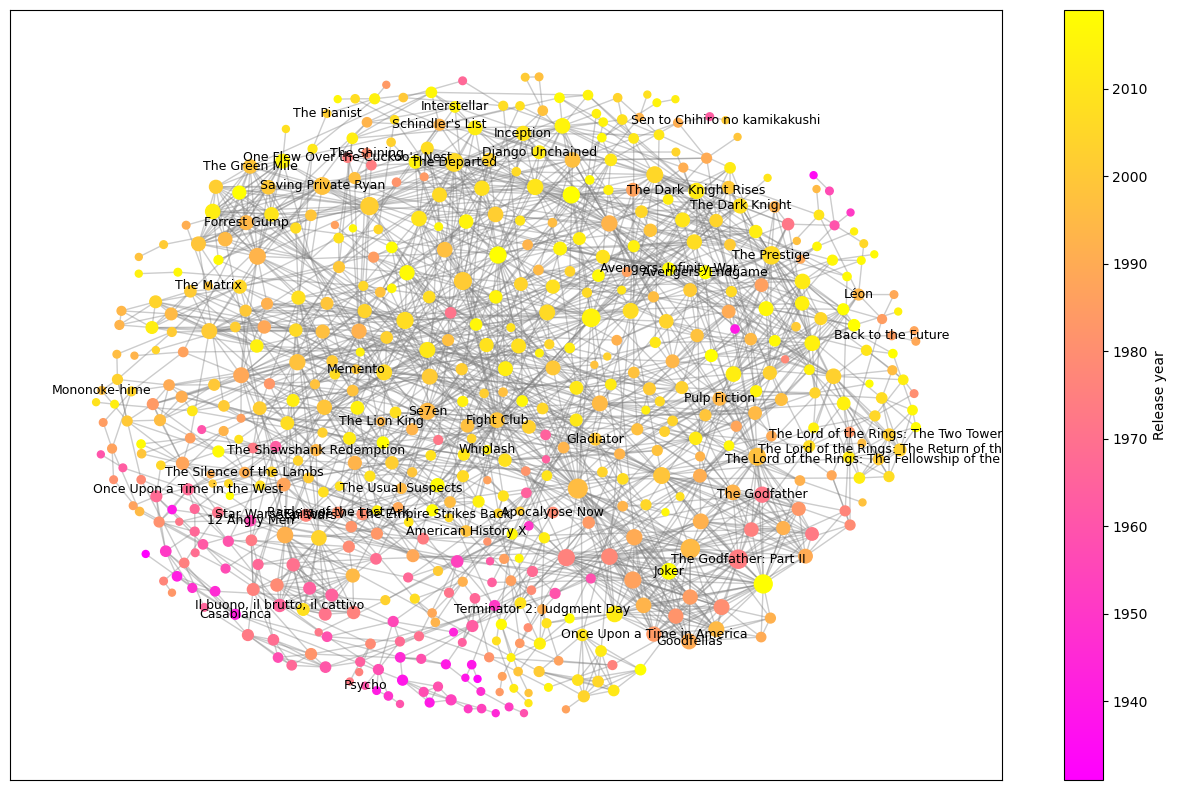

In [170]:
plt.style.use('default')

# # Find node size
degrees = dict(G_largest.degree())
node_sizes = [20 + deg * 5 for deg in degrees.values()] 

# Node colors
release_year = nx.get_node_attributes(G, "release_year")
node_colors = [release_year.get(n, 0) for n in G_largest.nodes()]

pos = nx.forceatlas2_layout(G_largest, max_iter=500, scaling_ratio=2.0, gravity=1.0, strong_gravity=True, seed=30)

plt.figure(figsize=(16, 10))
nodes = nx.draw_networkx_nodes(G_largest, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.spring, alpha=1)
nx.draw_networkx_edges(G_largest, pos, edge_color="gray", alpha=0.4)

# top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:10]
# labels = {n: n for n in top_nodes}
# nx.draw_networkx_labels(G_largest, pos, labels, font_size=9, font_weight='normal') 

random_nodes = list(degrees.keys())[:50]
labels = {n: n for n in random_nodes}
nx.draw_networkx_labels(G_largest, pos, labels, font_size=9, font_weight='normal') 

plt.colorbar(nodes, label="Release year")
plt.show()

In [171]:
G.nodes["Sen to Chihiro no kamikakushi"]

{'release_year': 2001,
 'runtime': 125,
 'genre': ['Animation', 'Adventure', 'Family'],
 'rating': 8.6,
 'resume': "During her family's move to the suburbs, a sullen 10-year-old girl wanders into a world ruled by gods, witches, and spirits, and where humans are changed into beasts.",
 'director': 'Hayao Miyazaki',
 'stars': ['Daveigh Chase', 'Suzanne Pleshette', 'Miyu Irino', 'Rumi Hiiragi'],
 'no_of_votes': 651376,
 'gross': 10055859}

In [172]:
# Communities

louv_comm = louvain_communities(G_largest, seed=42)
print(f"Number of communities: {len(louv_comm)}")

M_louvain = nx.community.modularity(G_largest, louv_comm)
print(f"Modularity (Louvain communities): {M_louvain:.4f}")

Number of communities: 15
Modularity (Louvain communities): 0.6517


In [173]:
print("Community sizes:", [len(c) for c in louv_comm])

Community sizes: [50, 16, 13, 46, 46, 33, 53, 30, 40, 52, 21, 58, 31, 41, 43]


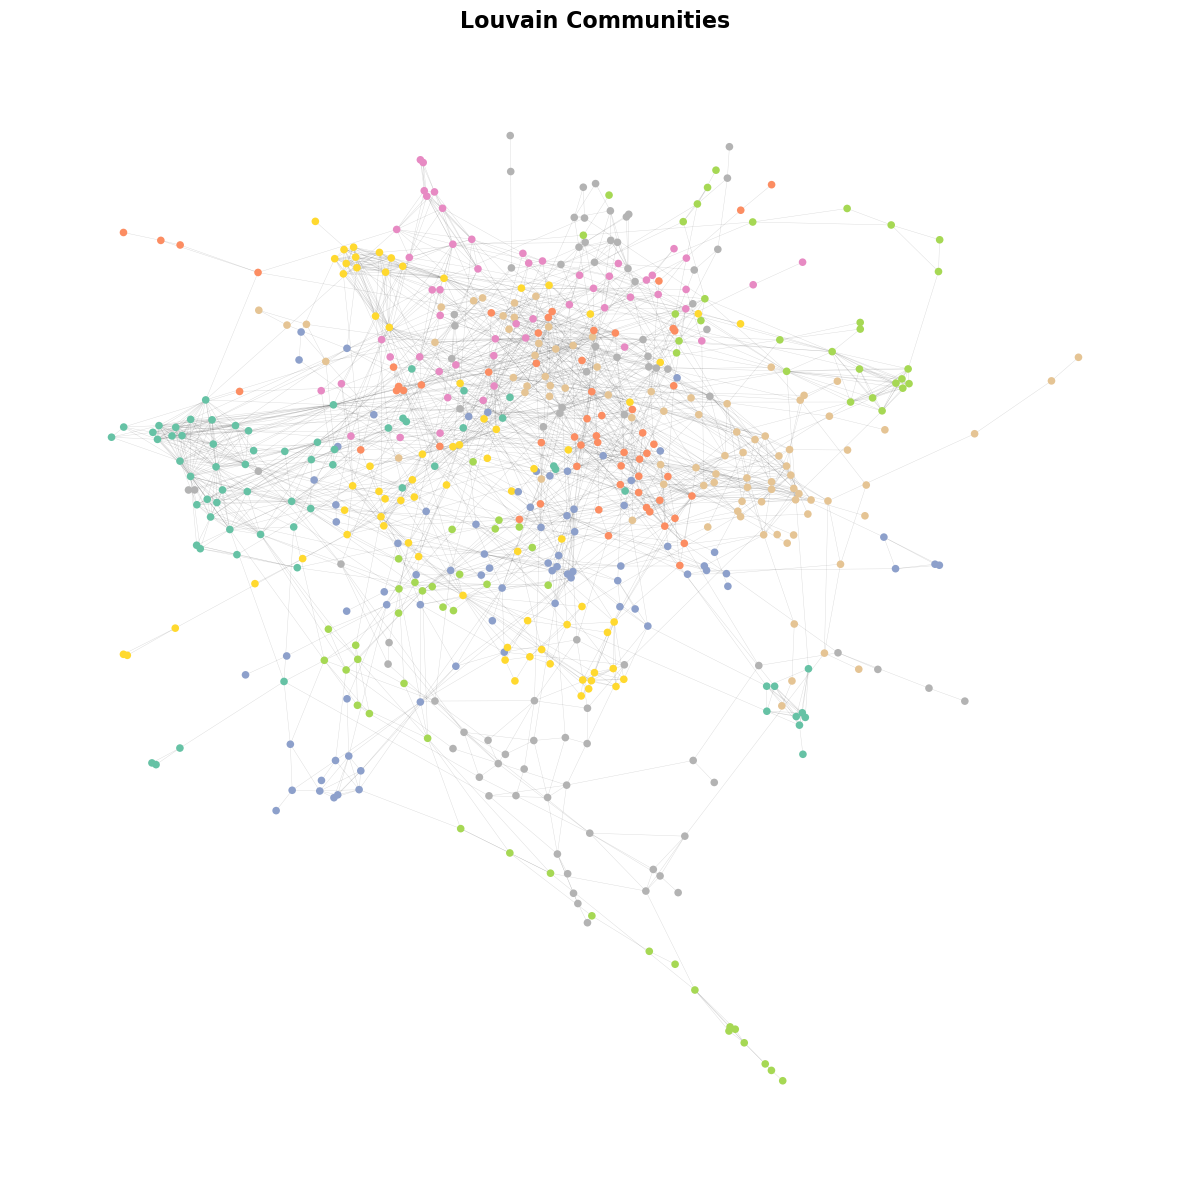

In [174]:
pos = nx.forceatlas2_layout(G, gravity=1.0, seed=25)

top_nodes = set().union(*louv_comm)

# Coloring
colors = plt.cm.Set2(np.linspace(0, 1, len(louv_comm)))
color_map = {}
for i, comm in enumerate(louv_comm):
    for node in comm:
        color_map[node] = colors[i]

node_colors = [color_map.get(n, (0.8, 0.8, 0.8, 0.25)) for n in G_largest.nodes()]

# Plot
plt.figure(figsize=(12, 12))
nx.draw_networkx_edges(G_largest, pos, alpha=0.15, width=0.3, edge_color="black")
nx.draw_networkx_nodes(
    G_largest,
    pos,
    node_size=30,
    node_color=node_colors,
    linewidths=0.1,
    edgecolors="none",
)
plt.title("Louvain Communities", fontsize=16, fontweight="bold")
plt.axis("off")
plt.tight_layout()
plt.show()

In [175]:
# Community info

deg_cent = nx.degree_centrality(G_largest)

community_info = []

for i, comm in enumerate(louv_comm):
    comm_deg = {n: deg_cent[n] for n in comm}
    top3 = sorted(comm_deg.items(), key=lambda x: x[1], reverse=True)[:3]
    top3_movies = [n.replace("_", " ") for n, _ in top3]

    all_genres = []
    for node in comm:
        g = G_largest.nodes[node].get("genre")
        all_genres.extend(g)
    common_genres = [g for g, _ in Counter(all_genres).most_common(1)]

    community_info.append({
        "Community": f"C{i}",
        "Top movies": ", ".join(top3_movies),
        "Top genres": ", ".join(common_genres),
    })

community_df = pd.DataFrame(community_info)

community_df

Community                                         Top movies Top genres
0         C0             Sleepers, The Godfather: Part II, Heat      Drama
1         C1  The Revenant, About Time, Harry Potter and the...  Adventure
2         C2         October Sky, Prisoners, Brokeback Mountain      Drama
3         C3          The Departed, The Big Short, The Prestige      Drama
4         C4        Rain Man, Edge of Tomorrow, Minority Report      Drama
5         C5      Blade Runner 2049, The Fugitive, The Notebook     Action
6         C6               American Gangster, Glory, Inside Man      Drama
7         C7  Unforgiven, Million Dollar Baby, The Bridges o...      Drama
8         C8                       JFK, On the Waterfront, Léon      Drama
9         C9  What's Eating Gilbert Grape, Titanic, Pirates ...      Drama
10       C10  Catch Me If You Can, Saving Private Ryan, Phil...      Drama
11       C11  Shutter Island, Captain America: The Winter So...      Drama
12       C12  Ocean's Eleven, Once Upon a Time... in Hollywo...      Drama
13       C13  The Big Lebowski, Only the Brave, Le Petit Prince      Drama
14       C14  Once Upon a Time in the West, The Lion in Wint...      Drama

In [176]:
# Backbone
def backbone_low_betweenness(G_largest, n_remove):
    # Work on a copy
    Gb = G_largest.copy()

    # Compute edge betweenness
    ebc = nx.edge_betweenness_centrality(Gb)

    # Sort edges: lowest betweenness first
    edges_sorted = sorted(ebc.items(), key=lambda x: x[1])

    # Select lowest n_remove edges
    edges_to_remove = [edge for edge, score in edges_sorted[:n_remove]]

    # Remove edges
    Gb.remove_edges_from(edges_to_remove)

    # Remove isolated nodes
    isolated = list(nx.isolates(Gb))
    Gb.remove_nodes_from(isolated)

    return Gb


# --- Run ---
G_backbone = backbone_low_betweenness(G_largest, n_remove=int(G_largest.number_of_edges()*0.85))


print("Nodes:", G_backbone.number_of_nodes())
print("Edges:", G_backbone.number_of_edges())

Nodes: 290
Edges: 323


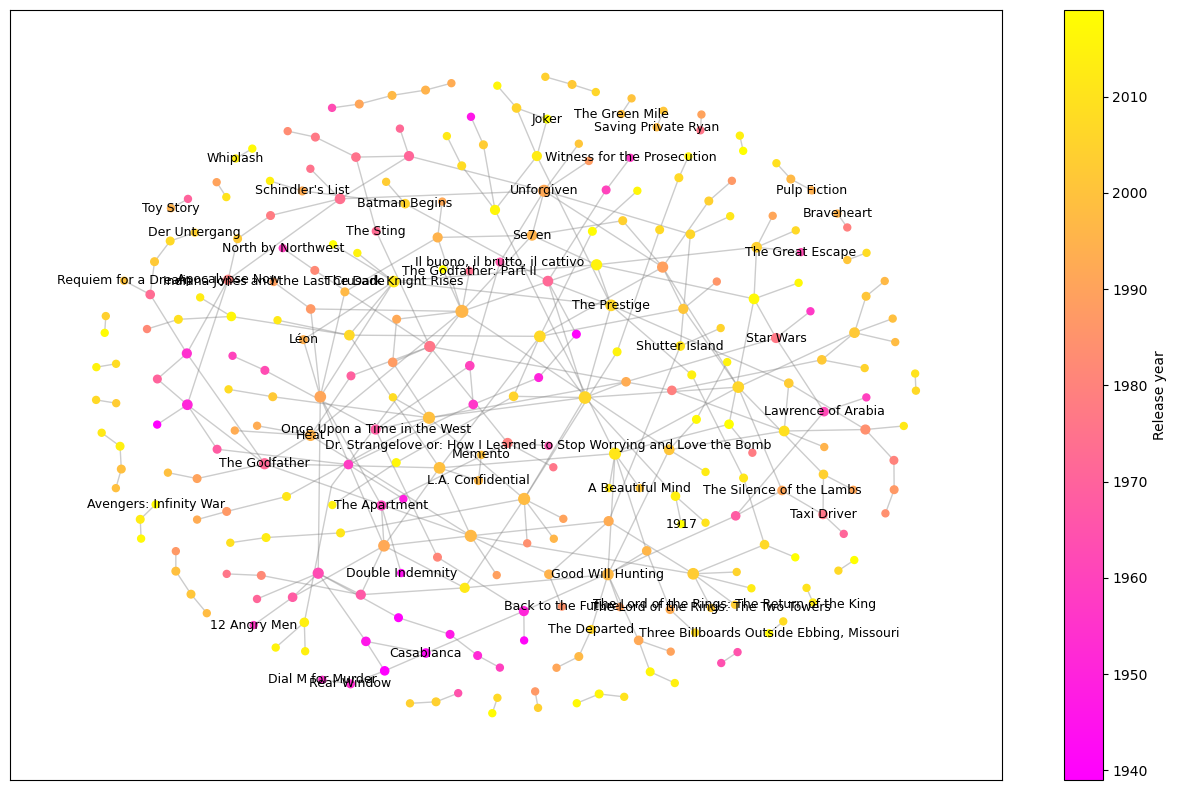

In [178]:
# # Find node size
degrees_backbone = dict(G_backbone.degree())
backbone_node_sizes = [20 + deg * 5 for deg in degrees_backbone.values()]

# Node colors
release_year = nx.get_node_attributes(G_backbone, "release_year")
node_colors = [release_year.get(n, 0) for n in G_backbone.nodes()]

pos = nx.forceatlas2_layout(G_backbone, max_iter=500, scaling_ratio=2.0, gravity=1.0, strong_gravity=True, seed=30)

plt.figure(figsize=(16, 10))
nodes = nx.draw_networkx_nodes(G_backbone, pos, node_size=backbone_node_sizes, node_color=node_colors, cmap=plt.cm.spring, alpha=1)
nx.draw_networkx_edges(G_backbone, pos, edge_color="gray", alpha=0.4)

random_nodes = list(degrees_backbone.keys())[:50]
labels = {n: n for n in random_nodes}
nx.draw_networkx_labels(G_backbone, pos, labels, font_size=9, font_weight='normal') 

plt.colorbar(nodes, label="Release year")
plt.show()

In [191]:
# Partitioning after genre (except for drama)

# Based on the first genre
genre_part = {}
for n, data in G_largest.nodes(data=True):
    genres = data.get("genre")
    if genres[0].lower() == "drama" and len(genres) > 1:
        genre_part[n] = genres[1]
    else:
        genre_part[n] = genres[0]

# Splitting into communities
genre_comm = defaultdict(list)
for node, genre in genre_part.items():
    genre_comm[genre].append(node)


M_genres = nx.community.modularity(G_largest, list(genre_comm.values()))
print(f"Modularity (genre partition): {M_genres:.4f}")

for genre, nodes in genre_comm.items():
    print(f"{genre}: {len(nodes)} films")


Modularity (genre partition): 0.0962
Drama: 44 films
Crime: 65 films
Action: 108 films
Biography: 69 films
Romance: 25 films
Western: 7 films
Adventure: 46 films
Animation: 36 films
War: 5 films
Music: 6 films
Mystery: 24 films
Horror: 14 films
Comedy: 83 films
Thriller: 10 films
Sport: 5 films
Film-Noir: 5 films
History: 8 films
Family: 2 films
Fantasy: 5 films
Sci-Fi: 6 films


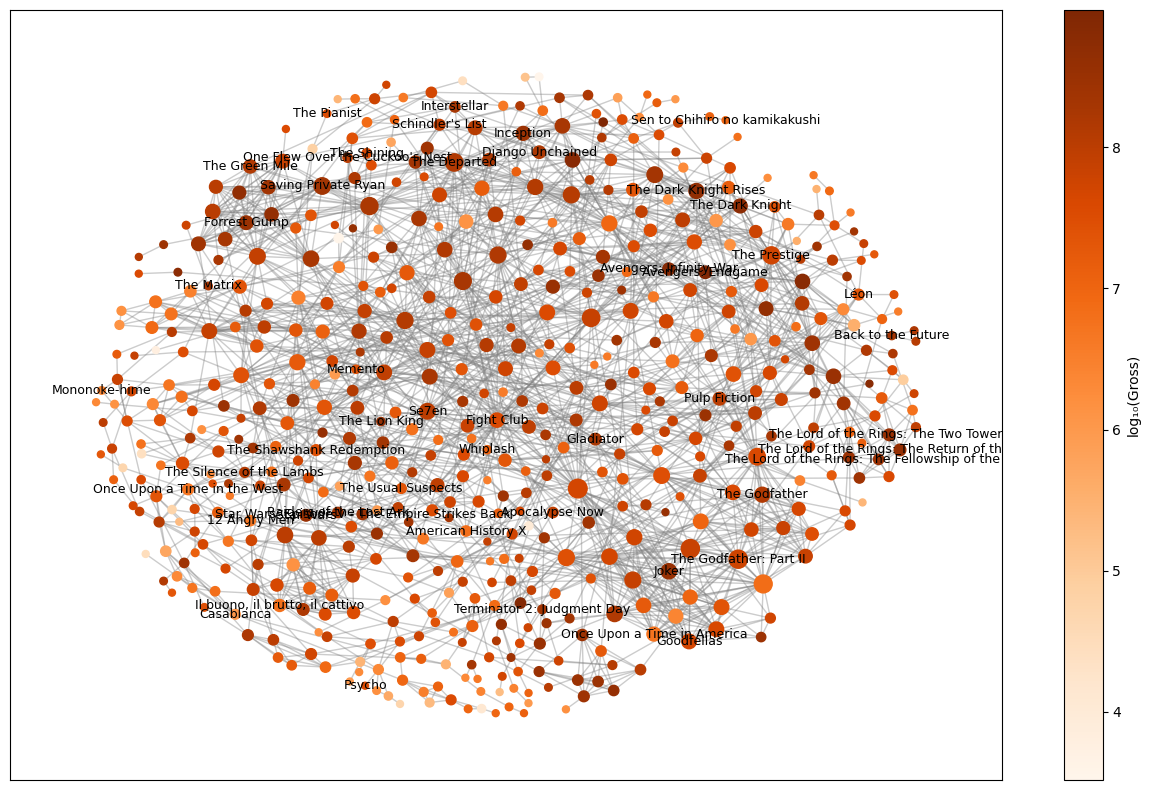

In [209]:
plt.style.use('default')

# # Find node size
degrees = dict(G_largest.degree())
node_sizes = [20 + deg * 5 for deg in degrees.values()] 

# Node colors
gross = nx.get_node_attributes(G, "gross")
node_colors = [np.log10(gross.get(n, 1)) for n in G_largest.nodes()]

pos = nx.forceatlas2_layout(G_largest, max_iter=500, scaling_ratio=2.0, gravity=1.0, strong_gravity=True, seed=30)

plt.figure(figsize=(16, 10))
nodes = nx.draw_networkx_nodes(G_largest, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.Oranges, alpha=1)
nx.draw_networkx_edges(G_largest, pos, edge_color="gray", alpha=0.4)

# top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:10]
# labels = {n: n for n in top_nodes}
# nx.draw_networkx_labels(G_largest, pos, labels, font_size=9, font_weight='normal') 

random_nodes = list(degrees.keys())[:50]
labels = {n: n for n in random_nodes}
nx.draw_networkx_labels(G_largest, pos, labels, font_size=9, font_weight='normal') 

cbar = plt.colorbar(nodes)
cbar.set_label("log₁₀(Gross)")
plt.show()